# Import Data

**olist_customers_dataset** : customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state

**olist_geolocation_dataset** : geolocation_zip_code_prefix	geolocation_lat	geolocation_lng	geolocation_city	geolocation_state

**olist_order_items_dataset**: order_id	order_item_id	product_id	seller_id	shipping_limit_date	price	freight_value

**olist_order_payments_dataset**: order_id	payment_sequential	payment_type	payment_installments	payment_value

**olist_order_reviews_dataset**: review_id	order_id	review_score	review_comment_title	review_comment_message	review_creation_date	review_answer_timestamp

**olist_orders_dataset**: order_id	customer_id	order_status	order_purchase_timestamp	order_approved_at	order_delivered_carrier_date	order_delivered_customer_date	order_estimated_delivery_date

**olist_products_dataset**: product_id	product_category_name	product_name_lenght	product_description_lenght	product_photos_qty	product_weight_g	product_length_cm	product_height_cm	product_width_cm

**olist_sellers_dataset**: seller_id	seller_zip_code_prefix	seller_city	seller_state

**product_category_name_translation**: product_category_name	product_category_name_english

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
import pandas as pd
customers = pd.read_csv('/content/gdrive/MyDrive/Tugas Akhir/data/olist_customers_dataset.csv')
geolocation = pd.read_csv('/content/gdrive/MyDrive/Tugas Akhir/data/olist_geolocation_dataset.csv')
order_items = pd.read_csv('/content/gdrive/MyDrive/Tugas Akhir/data/olist_order_items_dataset.csv')
order_payments = pd.read_csv('/content/gdrive/MyDrive/Tugas Akhir/data/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('/content/gdrive/MyDrive/Tugas Akhir/data/olist_order_reviews_dataset.csv')
orders = pd.read_csv('/content/gdrive/MyDrive/Tugas Akhir/data/olist_orders_dataset.csv')
products = pd.read_csv('/content/gdrive/MyDrive/Tugas Akhir/data/olist_products_dataset.csv')
sellers = pd.read_csv('/content/gdrive/MyDrive/Tugas Akhir/data/olist_sellers_dataset.csv')
category_translation = pd.read_csv('/content/gdrive/MyDrive/Tugas Akhir/data/product_category_name_translation.csv')

# Mengolah Data

buat data frame baru dengan kolom order_purchase_timestamp	product_category_name_english	product_category_name	order_id	order_item_id	product_id	seller_id	price

In [ ]:
merged_data = pd.merge(orders[['order_id', 'order_purchase_timestamp', 'customer_id']],
                        order_items[['order_id', 'order_item_id', 'product_id', 'seller_id', 'price']],
                        on='order_id', how='left')

merged_data = pd.merge(merged_data, products[['product_id', 'product_category_name']],
                        on='product_id', how='left')

merged_data = pd.merge(merged_data, category_translation[['product_category_name', 'product_category_name_english']],
                        on='product_category_name', how='left')


untuk menghitung quantity dari barang yang dibeli pada satu pesanan, dapat dilakukan dengan melakukan group by order_id and product_id and then sum the quantities.

In [ ]:
# Group by 'order_id' and 'product_id' buat tau quantity product yg di beli tiap ordernya
product_quantity_per_order = merged_data.groupby(['order_id', 'product_id'])['order_item_id'].count().reset_index()
product_quantity_per_order = product_quantity_per_order.rename(columns={'order_item_id': 'quantity_per_order'})

# gabungin quantity ke dataframe utama
merged_data = pd.merge(merged_data, product_quantity_per_order, on=['order_id', 'product_id'], how='left')

# ubah urutan kolom
merged_data = merged_data[['order_purchase_timestamp', 'customer_id', 'product_category_name_english',
                            'order_id', 'order_item_id', 'product_id',
                           'seller_id', 'price', 'quantity_per_order']]


In [ ]:
# munculin yang order lebih dari 1 item di satu kali order
merged_data[merged_data['order_item_id'] > 1].head()

,order_purchase_timestamp,customer_id,product_category_name_english,order_id,order_item_id,product_id,seller_id,price,quantity_per_order
11,2017-05-16 19:41:10,494dded5b201313c64ed7f100595b95c,garden_tools,e6ce16cb79ec1d90b1da9085a6118aeb,2.0,08574b074924071f4e201e151b152b4e,001cca7ae9ae17fb1caed9dfb1094831,99.00,2.0
28,2018-06-04 00:00:13,7e20bf5ca92da68200643bda76c504c6,baby,acce194856392f074dbf9dada14d8d82,2.0,9451e630d725c4bb7a5a206b48b99486,d673a59aac7a70d8b01e6902bf090a11,39.50,1.0
55,2018-07-26 14:39:59,79183cd650e2bb0d475b0067d45946ac,sports_leisure,9faeb9b2746b9d7526aef5acb08e2aa0,2.0,f48eb5c2fde13ca63664f0bb05f55346,f7ba60f8c3f99e7ee4042fdef03b70c4,60.00,2.0
61,2018-03-09 14:50:15,684fa6da5134b9e4dab731e00011712d,telephony,66e4624ae69e7dc89bd50222b59f581f,2.0,b37b72d5a56f887725c2862184b8cab8,db4350fd57ae30082dec7acbaacc17f9,22.99,2.0
69,2018-04-22 08:48:13,81e08b08e5ed4472008030d70327c71f,luggage_accessories,688052146432ef8253587b930b01a06d,2.0,db56f6d2b04c89eae4daba188842fd7b,2a84855fd20af891be03bc5924d2b453,199.00,1.0


## Filtering Data

Tunjukan semua product_id yang terduplikasi

hanya akan digunakan file dengan product_id terduplicated terbanyak

In [ ]:
# munculin row yang punya duplicated product_id dan lebih dari dua seller_id berbeda
duplicated_products = merged_data[merged_data.duplicated(subset=['product_id'], keep=False)]
more_than_two_sellers = duplicated_products.groupby('product_id')['seller_id'].nunique() > 2
filtered_products = more_than_two_sellers[more_than_two_sellers].index
filtered_products

Index(['027cdd14a677a5834bc67a9789db5021', '02f8dd9b448d3ec2c73e65a22da1121c',
       '049ac5dce8536884a652ce73c58022ab', '04df667e73ca2fab4b9a97c86466b699',
       '059ca09d32720d9adce3ae12e181339d', '073ed404e3aec5b0a486334c05ee2fe9',
       '086351823300e0339f6955b27998c186', '09982590713913e225d3ce5ccb670688',
       '0c71252f37443403376d2008034a7240', '0d009643171aee696f4733340bc2fdd0',
       ...
       'eaa26a34984cbfedc19b1e45f09f3c9a', 'ec268f069320a08af47861967e4d7bee',
       'ee57070aa3b24a06fdd0e02efd2d757d', 'f081174cf4cde1e4f75cd45b4518bbe6',
       'f083f237cbf95dd0a5185e902f385dd5', 'f819f0c84a64f02d3a5606ca95edd272',
       'fb1c85ab4adb8f0fd63d3e2156e51f4b', 'fbc1488c1a1e72ba175f53ab29a248e8',
       'ffaf0af7eebb57c7f262b51ebb05dfd6', 'ffd2365fb8224dc66883df9351d65deb'],
      dtype='object', name='product_id', length=195)

In [ ]:
# pilih top 10 product_id yang paling banyak muncul
top_10_products = merged_data[merged_data['product_id'].isin(filtered_products)]
top_10_product_counts = top_10_products['product_id'].value_counts().nlargest(10).index
top_10_product_counts

Index(['53b36df67ebb7c41585e8d54d6772e08', 'e0d64dcfaa3b6db5c54ca298ae101d05',
       'e53e557d5a159f5aa2c5e995dfdf244b', '437c05a395e9e47f9762e677a7068ce7',
       '461f43be3bdf8844e65b62d9ac2c7a5a', '7a10781637204d8d10485c71a6108a2e',
       '656e0eca68dcecf6a31b8ececfabe3e8', '36f60d45225e60c7da4558b070ce4b60',
       'd285360f29ac7fd97640bf0baef03de0', '6f3b5b605d91b7439c5e3f5a8dffeea7'],
      dtype='object')

In [ ]:
product_dataframes = {}
# buat data frames terpisah dan export ke excel
for product_id in top_10_product_counts:
    product_df = top_10_products[top_10_products['product_id'] == product_id]
    product_dataframes[product_id] = product_df
    file_name = f"product_{product_id}_data.xlsx"  # File name for each DataFrame
    product_df.to_excel(file_name, index=False)

    print(f"DataFrame for product_id {product_id} exported to '{file_name}'.")

# print nama dataframe dan banyak rownya
for product_id, dataframe in product_dataframes.items():
    print(f"DataFrame for product_id {product_id} with {len(dataframe)} rows:")


DataFrame for product_id 53b36df67ebb7c41585e8d54d6772e08 exported to 'product_53b36df67ebb7c41585e8d54d6772e08_data.xlsx'.
DataFrame for product_id e0d64dcfaa3b6db5c54ca298ae101d05 exported to 'product_e0d64dcfaa3b6db5c54ca298ae101d05_data.xlsx'.
DataFrame for product_id e53e557d5a159f5aa2c5e995dfdf244b exported to 'product_e53e557d5a159f5aa2c5e995dfdf244b_data.xlsx'.
DataFrame for product_id 437c05a395e9e47f9762e677a7068ce7 exported to 'product_437c05a395e9e47f9762e677a7068ce7_data.xlsx'.
DataFrame for product_id 461f43be3bdf8844e65b62d9ac2c7a5a exported to 'product_461f43be3bdf8844e65b62d9ac2c7a5a_data.xlsx'.
DataFrame for product_id 7a10781637204d8d10485c71a6108a2e exported to 'product_7a10781637204d8d10485c71a6108a2e_data.xlsx'.
DataFrame for product_id 656e0eca68dcecf6a31b8ececfabe3e8 exported to 'product_656e0eca68dcecf6a31b8ececfabe3e8_data.xlsx'.
DataFrame for product_id 36f60d45225e60c7da4558b070ce4b60 exported to 'product_36f60d45225e60c7da4558b070ce4b60_data.xlsx'.
DataFram

In [ ]:
#product_dataframes['53b36df67ebb7c41585e8d54d6772e08']

# Notes Hasil Mengolah Data

DataFrame for product_id 53b36df67ebb7c41585e8d54d6772e08 exported to 'product_53b36df67ebb7c41585e8d54d6772e08_data.xlsx'.

DataFrame for product_id e0d64dcfaa3b6db5c54ca298ae101d05 exported to 'product_e0d64dcfaa3b6db5c54ca298ae101d05_data.xlsx'.

DataFrame for product_id e53e557d5a159f5aa2c5e995dfdf244b exported to 'product_e53e557d5a159f5aa2c5e995dfdf244b_data.xlsx'.

DataFrame for product_id 437c05a395e9e47f9762e677a7068ce7 exported to 'product_437c05a395e9e47f9762e677a7068ce7_data.xlsx'.

DataFrame for product_id 461f43be3bdf8844e65b62d9ac2c7a5a exported to 'product_461f43be3bdf8844e65b62d9ac2c7a5a_data.xlsx'.

DataFrame for product_id 7a10781637204d8d10485c71a6108a2e exported to 'product_7a10781637204d8d10485c71a6108a2e_data.xlsx'.

DataFrame for product_id 656e0eca68dcecf6a31b8ececfabe3e8 exported to 'product_656e0eca68dcecf6a31b8ececfabe3e8_data.xlsx'.

DataFrame for product_id 36f60d45225e60c7da4558b070ce4b60 exported to 'product_36f60d45225e60c7da4558b070ce4b60_data.xlsx'.

DataFrame for product_id d285360f29ac7fd97640bf0baef03de0 exported to 'product_d285360f29ac7fd97640bf0baef03de0_data.xlsx'.

DataFrame for product_id 6f3b5b605d91b7439c5e3f5a8dffeea7 exported to 'product_6f3b5b605d91b7439c5e3f5a8dffeea7_data.xlsx'.

# Mengolah data  product_id 53b36df67ebb7c41585e8d54d6772e08

In [ ]:
# read data
data = pd.read_excel('/content/product_53b36df67ebb7c41585e8d54d6772e08_data.xlsx')
data.head()

,order_purchase_timestamp,customer_id,product_category_name_english,order_id,order_item_id,product_id,seller_id,price,quantity_per_order
0,2018-05-08 19:48:01,ad4da04c9e20699c6ad1843af39846d2,watches_gifts,d62387acb3914789e712406e9882e549,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,99.9,1
1,2018-05-05 09:22:24,fdabedbba76cf0308dedcd99afc66626,watches_gifts,a2ea081c06c12c25c068089e4985745a,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,110.0,1
2,2018-05-08 21:04:16,f4302056f0c58570522590f8181de2c7,watches_gifts,d0bec96aad189992b278688279ba1511,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,99.9,1
3,2017-09-03 21:38:55,d0836b848a9c6d8fe285a19b028df814,watches_gifts,f594ab1eab2b9d5a646c989c1bc5eb3e,1,53b36df67ebb7c41585e8d54d6772e08,4869f7a5dfa277a7dca6462dcf3b52b2,169.9,1
4,2018-04-27 15:58:41,88a8cf9e243fe33b9b678a31eb640f70,watches_gifts,9bd90698ab1e822ca4cb1e2a0de42fd4,1,53b36df67ebb7c41585e8d54d6772e08,7d13fca15225358621be4086e1eb0964,99.9,1


In [ ]:
# cari seller_id yang berbeda
unique_seller_ids = data['seller_id'].unique()

var_name = []
# buat data frames terpisah untuk setiap seller_id
n = 0
for seller_id in unique_seller_ids:
    seller_data = data[data['seller_id'] == seller_id]

    # buat nama variabel untuk data_frames (exp, data_seller1, data_seller2, ...)
    n = n+1
    variable_name = 'data_seller' + str(n)
    var_name.append(variable_name)

    # assign filtered dataframe ke nama varnya
    globals()[variable_name] = seller_data.copy()

    # Pastiin ke run
    print(f"DataFrame {variable_name} created for seller_id: {seller_id}")

DataFrame data_seller1 created for seller_id: 7d13fca15225358621be4086e1eb0964
DataFrame data_seller2 created for seller_id: 4869f7a5dfa277a7dca6462dcf3b52b2
DataFrame data_seller3 created for seller_id: 58f1a6197ed863543e0136bdedb3fce2


In [ ]:
var_name

In [ ]:
data_seller3.head()

,order_purchase_timestamp,customer_id,product_category_name_english,order_id,order_item_id,product_id,seller_id,price,quantity_per_order
18,2018-07-17 22:44:42,643c75fed93c5f43541eaf9c6c8b4828,watches_gifts,066a60f7b0700a942ba22b627ebff13b,1,53b36df67ebb7c41585e8d54d6772e08,58f1a6197ed863543e0136bdedb3fce2,119.0,1
22,2018-07-05 18:57:13,5b44eea88fb939f313c15cb15583094c,watches_gifts,c05a5defefe139269bfc13a22fbe8543,1,53b36df67ebb7c41585e8d54d6772e08,58f1a6197ed863543e0136bdedb3fce2,119.0,1
190,2018-07-10 16:53:01,c1376f3aeb94f912ba838eea99b8667a,watches_gifts,88378ffe8de3a4e0d7ef03e71010d618,1,53b36df67ebb7c41585e8d54d6772e08,58f1a6197ed863543e0136bdedb3fce2,119.0,1


In [ ]:
# buat dataframe gabungan untuk include semua order_purchase_timestamp (pake outer)
merged_data_1 = pd.merge(data_seller1, data_seller2, on='order_purchase_timestamp', suffixes=('_seller1', '_seller2'), how='outer')
merged_data_1 = pd.merge(merged_data_1, data_seller3, on='order_purchase_timestamp', suffixes=('', '_seller3'), how='outer')

# sort berdasar waktu
merged_data_1.sort_values(by='order_purchase_timestamp', inplace=True)

merged_data_1.head()

,order_purchase_timestamp,customer_id_seller1,product_category_name_english_seller1,order_id_seller1,order_item_id_seller1,product_id_seller1,seller_id_seller1,price_seller1,quantity_per_order_seller1,customer_id_seller2,...,price_seller2,quantity_per_order_seller2,customer_id,product_category_name_english,order_id,order_item_id,product_id,seller_id,price,quantity_per_order
298,2017-06-11 13:04:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142a4e4e5238d5ff64a7cd659ec0f95e,...,163.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,2017-06-12 09:15:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72cb30eee8406d375e223bf6532f6c4a,...,163.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,2017-06-22 11:54:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24e69f16d58f72c3cf950598399a16a5,...,163.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266,2017-06-27 11:18:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9438a63c1d4be3c9a73c551d59804886,...,163.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248,2017-07-14 09:22:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,670a432cf10d38da64efeaf03fcf6385,...,163.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#export ke excel
file_name = 'merged_data_1.xlsx'
merged_data_1.to_excel(file_name, index=False)

print(f"Data exported to '{file_name}' successfully.")

Data exported to 'merged_data_1.xlsx' successfully.


for
product_category_name_english_seller1, product_category_name_english_seller2, product_category_name_english fill in the NaN with the value of the other cells that is not NaN in the same column

for
customer_id_seller1 order_id_seller1	order_item_id_seller1	product_id_seller1	seller_id_seller1 quantity_per_order_seller1 customer_id_seller2 order_id_seller2	order_item_id_seller2	product_id_seller2	seller_id_seller2 quantity_per_order_seller2 customer_id	order_id	order_item_id	product_id	seller_id	quantity_per_order
fill in the NaN with 0

lastly for
price_seller1 price_seller2 price_seller3  assume that the value stay the same as the previous one for the date where it is NaN, if there is no previous data, then used the first data found after all the NaN



untuk product category dan price If the first value is NaN, fill it with the first non-NaN value found in the column.
If the first value is not NaN, fill it with the previous non-NaN value available.

used the fact that if the first index is NaN or TRUE, then         # If the first value is NaN, fill it with the first non-NaN value found in the column
        first_non_nan = df[col].first_valid_index()
        first_non_nan_value = df.at[first_non_nan, col]
        df[col].fillna(first_non_nan_value, inplace=True)

and if it is not NaN or false then         # If the first value is not NaN, fill it with the previous non-NaN value available
        df[col].fillna(method='ffill', inplace=True)

In [ ]:
import pandas as pd
import numpy as np

# Read file excel
file_path = 'merged_data_1.xlsx'
df = pd.read_excel(file_path)

# Filling NaN di 'product_category_name_english_seller1', 'product_category_name_english_seller2', 'product_category_name_english' columns
category_columns = ['product_category_name_english_seller1', 'product_category_name_english_seller2', 'product_category_name_english']

for col in category_columns:
    # Cek nan ato ga first value
    first_value_is_nan = pd.isnull(df.at[0, col])

    if first_value_is_nan:
        # jika nan, di fill dengan value yang ga nan pertama di kolom tersebut
        first_non_nan = df[col].first_valid_index()
        first_non_nan_value = df.at[first_non_nan, col]
        df[col].fillna(first_non_nan_value, inplace=True)
    else:
        # jika ga nan fill dengan previous value
        df[col].fillna(method='ffill', inplace=True)

In [ ]:
# Fill NaN dengan 0
specific_columns = ['customer_id_seller1', 'order_id_seller1', 'order_item_id_seller1', 'product_id_seller1', 'seller_id_seller1', 'quantity_per_order_seller1',
                    'customer_id_seller2', 'order_id_seller2', 'order_item_id_seller2', 'product_id_seller2', 'seller_id_seller2', 'quantity_per_order_seller2',
                    'customer_id', 'order_id', 'order_item_id', 'product_id', 'seller_id', 'quantity_per_order']
df[specific_columns] = df[specific_columns].fillna(0)

In [ ]:
df.head()

,order_purchase_timestamp,customer_id_seller1,product_category_name_english_seller1,order_id_seller1,order_item_id_seller1,product_id_seller1,seller_id_seller1,price_seller1,quantity_per_order_seller1,customer_id_seller2,...,price_seller2,quantity_per_order_seller2,customer_id,product_category_name_english,order_id,order_item_id,product_id,seller_id,price,quantity_per_order
0,2017-06-11 13:04:43,0,watches_gifts,0,0.0,0,0,NaN,0.0,142a4e4e5238d5ff64a7cd659ec0f95e,...,163.0,1.0,0,watches_gifts,0,0.0,0,0,NaN,0.0
1,2017-06-12 09:15:35,0,watches_gifts,0,0.0,0,0,NaN,0.0,72cb30eee8406d375e223bf6532f6c4a,...,163.0,1.0,0,watches_gifts,0,0.0,0,0,NaN,0.0
2,2017-06-22 11:54:35,0,watches_gifts,0,0.0,0,0,NaN,0.0,24e69f16d58f72c3cf950598399a16a5,...,163.0,1.0,0,watches_gifts,0,0.0,0,0,NaN,0.0
3,2017-06-27 11:18:43,0,watches_gifts,0,0.0,0,0,NaN,0.0,9438a63c1d4be3c9a73c551d59804886,...,163.0,1.0,0,watches_gifts,0,0.0,0,0,NaN,0.0
4,2017-07-14 09:22:32,0,watches_gifts,0,0.0,0,0,NaN,0.0,670a432cf10d38da64efeaf03fcf6385,...,163.0,1.0,0,watches_gifts,0,0.0,0,0,NaN,0.0


In [ ]:
# fill NaN di 'price_seller1', 'price_seller2', 'price_seller3' columns
price_columns = ['price_seller1', 'price_seller2', 'price']


for col in price_columns:
    first_value_is_nan = pd.isnull(df.at[0, col])

    if first_value_is_nan:
        first_non_nan = df[col].first_valid_index()
        first_non_nan_value = df.at[first_non_nan, col]
        df[col].fillna(first_non_nan_value, inplace=True)
    else:
        df[col].fillna(method='ffill', inplace=True)

output_file_path = 'merged_data_1.xlsx'
df.to_excel(output_file_path, index=False)
print(f"Data exported to '{output_file_path}' successfully.")

Data exported to 'merged_data_1.xlsx' successfully.


In [ ]:
df.head()

,order_purchase_timestamp,customer_id_seller1,product_category_name_english_seller1,order_id_seller1,order_item_id_seller1,product_id_seller1,seller_id_seller1,price_seller1,quantity_per_order_seller1,customer_id_seller2,...,price_seller2,quantity_per_order_seller2,customer_id,product_category_name_english,order_id,order_item_id,product_id,seller_id,price,quantity_per_order
0,2017-06-11 13:04:43,0,watches_gifts,0,0.0,0,0,125.0,0.0,142a4e4e5238d5ff64a7cd659ec0f95e,...,163.0,1.0,0,watches_gifts,0,0.0,0,0,119.0,0.0
1,2017-06-12 09:15:35,0,watches_gifts,0,0.0,0,0,125.0,0.0,72cb30eee8406d375e223bf6532f6c4a,...,163.0,1.0,0,watches_gifts,0,0.0,0,0,119.0,0.0
2,2017-06-22 11:54:35,0,watches_gifts,0,0.0,0,0,125.0,0.0,24e69f16d58f72c3cf950598399a16a5,...,163.0,1.0,0,watches_gifts,0,0.0,0,0,119.0,0.0
3,2017-06-27 11:18:43,0,watches_gifts,0,0.0,0,0,125.0,0.0,9438a63c1d4be3c9a73c551d59804886,...,163.0,1.0,0,watches_gifts,0,0.0,0,0,119.0,0.0
4,2017-07-14 09:22:32,0,watches_gifts,0,0.0,0,0,125.0,0.0,670a432cf10d38da64efeaf03fcf6385,...,163.0,1.0,0,watches_gifts,0,0.0,0,0,119.0,0.0


## Tahap Pencarian Best Response Function

### Menghitung Elastisitas $a_1,a_2,...,a_n$

Menggunakan regresi agar

There are several main reasons people use regression analysis:

To predict future economic conditions, trends, or values

To determine the relationship between two or more variables

**To understand how one variable changes when another changes**
https://www.investopedia.com/ask/answers/060315/what-difference-between-linear-regression-and-multiple-regression.asp

An independent variable is the variable that is changed or controlled in a scientific experiment to test the effects on the dependent variable. A dependent variable is the variable being tested and measured in a scientific experiment. The dependent variable is 'dependent' on the independent variable.

https://medium.com/nerd-for-tech/a-unique-intersection-of-game-theory-and-data-science-e-commerce-product-pricing-659a4c877261

file:///D:/Asus/Documents/Kuliah/Jurusan/sem%207/TA/sumber%20sendiri/A%20Unique%20Intersection%20of%20Game%20Theory%20and%20Data%20Science_%20E-Commerce%20Product%20Pricing%20_%20by%20Kowshik%20chilamkurthy%20_%20Nerd%20For%20Tech%20_%20Medium.pdf


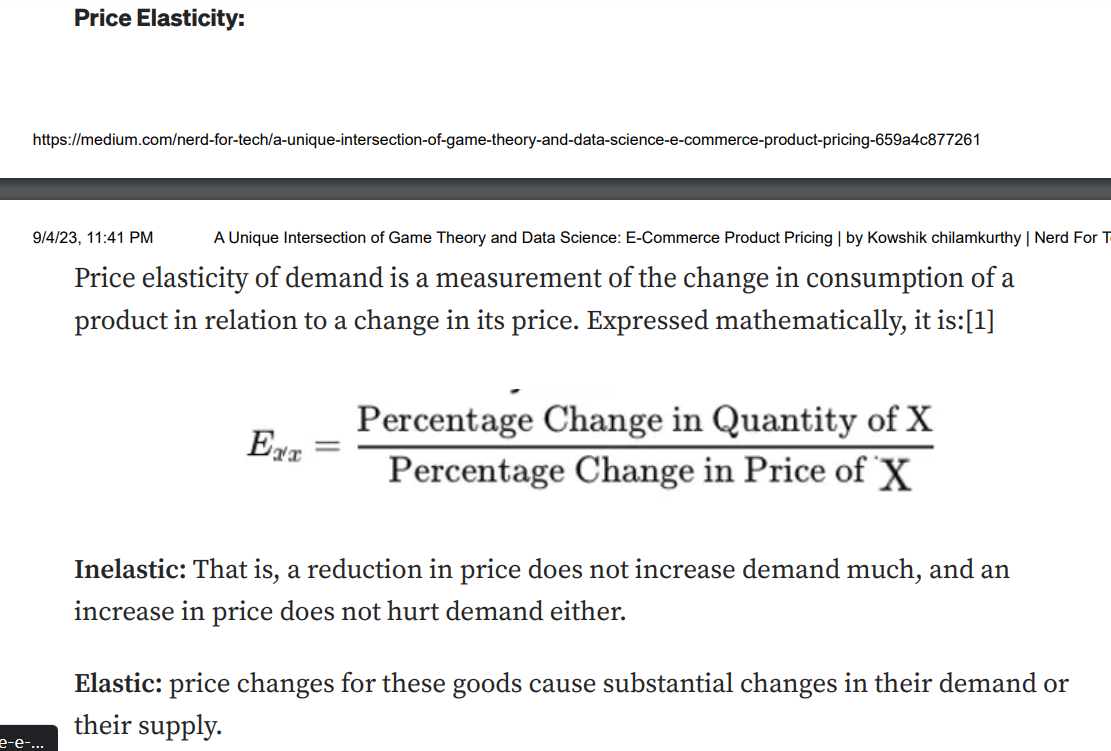

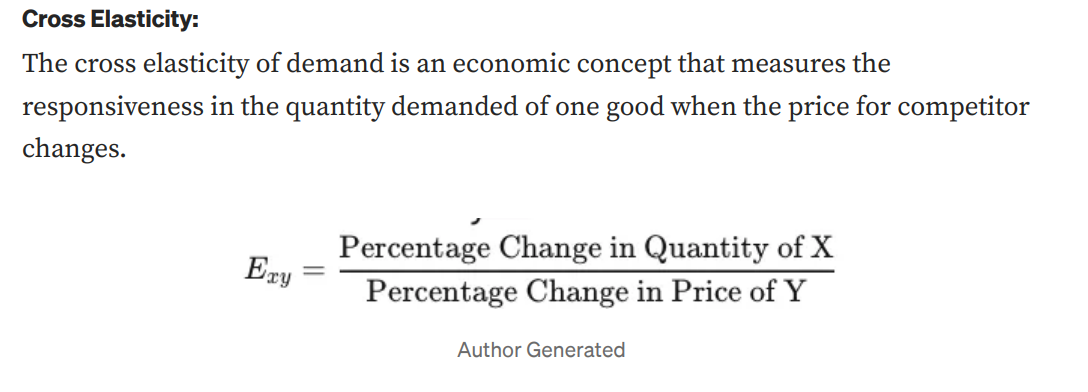

Directly use demand(Q) as dependent variable(Y) and price(p) as independent
variable(X).

X = Price

Y = Quantity/demand/sales


https://openstax.org/books/introductory-business-statistics/pages/13-5-interpretation-of-regression-coefficients-elasticity-and-logarithmic-transformation
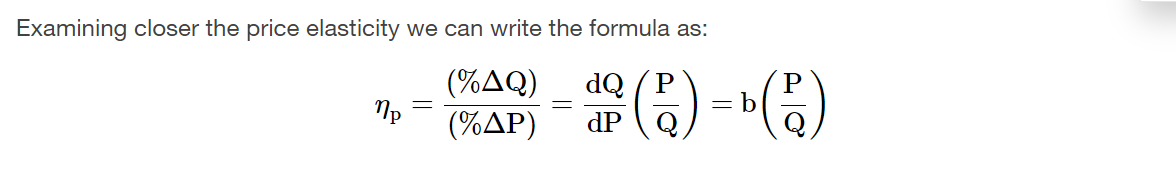

#### Y = quantity seller 1, terhadap x

In [ ]:
import pandas as pd
import statsmodels.api as sm
df= pd.read_excel('/content/merged_data_1.xlsx')
# E11
X = df['price_seller1']
Y = df['quantity_per_order_seller1']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
# Get the coefficients from the regression results
coefficients = results.params

# Calculate price elasticity for seller 1
price_elasticity_seller1 = coefficients['price_seller1'] * (X['price_seller1'].mean() / Y.mean())
print(price_elasticity_seller1)
print(results.summary())

-6.524397664761436
                                OLS Regression Results                                
Dep. Variable:     quantity_per_order_seller1   R-squared:                       0.396
Model:                                    OLS   Adj. R-squared:                  0.394
Method:                         Least Squares   F-statistic:                     210.7
Date:                        Tue, 05 Dec 2023   Prob (F-statistic):           4.69e-37
Time:                                23:28:13   Log-Likelihood:                -304.38
No. Observations:                         323   AIC:                             612.8
Df Residuals:                             321   BIC:                             620.3
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

-0.0455 artinya kenaikan harga akan menyebabkan penurunan demand
5.9170 rata2 penjualan yang di expect dari yang tidak merubah harga

In [ ]:
# E12
X = df['price_seller2']
Y = df['quantity_per_order_seller1']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
# Get the coefficients from the regression results
coefficients = results.params

# Calculate cross elasticity for seller 12
cross_elasticity_seller12 = coefficients['price_seller2'] * (X['price_seller2'].mean() / Y.mean())
print(cross_elasticity_seller12)
print(results.summary())

-2.776555073536369
                                OLS Regression Results                                
Dep. Variable:     quantity_per_order_seller1   R-squared:                       0.176
Model:                                    OLS   Adj. R-squared:                  0.173
Method:                         Least Squares   F-statistic:                     68.33
Date:                        Tue, 05 Dec 2023   Prob (F-statistic):           3.70e-15
Time:                                23:28:13   Log-Likelihood:                -354.71
No. Observations:                         323   AIC:                             713.4
Df Residuals:                             321   BIC:                             721.0
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [ ]:
# E13
X = df['price']
Y = df['quantity_per_order_seller1']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
# Get the coefficients from the regression results
coefficients = results.params

# Calculate cross elasticity for seller 13
cross_elasticity_seller13 = coefficients['price'] * (X['price'].mean() / Y.mean())
print(cross_elasticity_seller13)
print(results.summary())

1.0
                                OLS Regression Results                                
Dep. Variable:     quantity_per_order_seller1   R-squared:                      -0.000
Model:                                    OLS   Adj. R-squared:                 -0.000
Method:                         Least Squares   F-statistic:                       nan
Date:                        Tue, 05 Dec 2023   Prob (F-statistic):                nan
Time:                                23:28:13   Log-Likelihood:                -385.88
No. Observations:                         323   AIC:                             773.8
Df Residuals:                             322   BIC:                             777.5
Df Model:                                   0                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

#### Y = quantity seller 2, X price

In [ ]:
# E21
X = df['price_seller1']
Y = df['quantity_per_order_seller2']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
# Get the coefficients from the regression results
coefficients = results.params

# Calculate cross elasticity for seller 12
cross_elasticity_seller21 = coefficients['price_seller1'] * (X['price_seller1'].mean() / Y.mean())
cross_elasticity_seller21

11.270264009252186

In [ ]:
# E22
X = df['price_seller2']
Y = df['quantity_per_order_seller2']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
# Get the coefficients from the regression results
coefficients = results.params

# Calculate cross elasticity for seller 12
price_elasticity_seller2 = coefficients['price_seller2'] * (X['price_seller2'].mean() / Y.mean())
price_elasticity_seller2

7.361353258982903

In [ ]:
# E23
X = df['price']
Y = df['quantity_per_order_seller2']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
# Get the coefficients from the regression results
coefficients = results.params

# Calculate cross elasticity for seller 13
cross_elasticity_seller23 = coefficients['price'] * (X['price'].mean() / Y.mean())
cross_elasticity_seller23

0.9999999999999998

#### Y = quantity seller 3, x price

In [ ]:
# E31
X = df['price_seller1']
Y = df['quantity_per_order']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
# Get the coefficients from the regression results
coefficients = results.params

# Calculate price elasticity for seller 1
cross_elasticity_seller31 = coefficients['price_seller1'] * (X['price_seller1'].mean() / Y.mean())
cross_elasticity_seller31

11.270264009252216

In [ ]:
# E32
X = df['price_seller2']
Y = df['quantity_per_order']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
# Get the coefficients from the regression results
coefficients = results.params

# Calculate cross elasticity for seller 12
cross_elasticity_seller32 = coefficients['price_seller2'] * (X['price_seller2'].mean() / Y.mean())
cross_elasticity_seller32

-1.4838468972822259

In [ ]:
X = df['price']
Y = df['quantity_per_order_seller2']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
# Get the coefficients from the regression results
coefficients = results.params

# Calculate cross elasticity for seller 13
price_elasticity_seller3 = coefficients['price'] * (X['price'].mean() / Y.mean())
price_elasticity_seller3

0.9999999999999998



---



### Matriks elastisitas

\begin{pmatrix}
-6.524397664761436 & -2.776555073536369 & 1.0\\
11.270264009252186 & 7.361353258982903 & 0.9999999999999998 \\
11.270264009252216 & -1.4838468972822259 & 0.9999999999999998
\end{pmatrix}

In [ ]:
A = [[-6.524397664761436, -2.776555073536369, 1],
    [11.270264009252186, 7.361353258982903, 0.9999999999999998],
     [11.270264009252216, -1.4838468972822259, 0.9999999999999998]]

Best Response:
$A-a_1p_1 + \sum_{i\neq j} a_j p_j$ = 0


untuk iterasi pertama

maka untuk mencari $p_1$
$$ p_1 = \frac{A}{a_1} + \frac{\sum_{i\neq j} a_j p_j}{a_1} $$
untuk kasus data ini
$$ p_1 = \frac{A}{a_{11}} + \frac{a_{12}p_2+a_{13}p_3}{a_{11}} $$

kemudian nilai $p_1$ yang baru akan digunakan untuk mencari $p_2$, yaitu
$$ p_2 = \frac{A}{a_{22}} + \frac{a_{21}p_1+a_{23}p_3}{a_{22}} $$

dan nilai dari $p_1$ dan $p_2$ akan digunakan untuk mencari p_3 dengan
$$ p_3 = \frac{A}{a_{33}} + \frac{a_{31}p_1+a_{32}p_2}{a_{33}} $$

iterasi kedua akan digunakan $p_1,p_2,p_3$ dari iterasi pertama dan diulangin sampai ditemukan kekonvergenan

*A adalah sum dari quantity


In [ ]:
df.head()

,order_purchase_timestamp,customer_id_seller1,product_category_name_english_seller1,order_id_seller1,order_item_id_seller1,product_id_seller1,seller_id_seller1,price_seller1,quantity_per_order_seller1,customer_id_seller2,...,price_seller2,quantity_per_order_seller2,customer_id,product_category_name_english,order_id,order_item_id,product_id,seller_id,price,quantity_per_order
0,2017-06-11 13:04:43,0,watches_gifts,0,0,0,0,125.0,0,142a4e4e5238d5ff64a7cd659ec0f95e,...,163.0,1,0,watches_gifts,0,0,0,0,119,0
1,2017-06-12 09:15:35,0,watches_gifts,0,0,0,0,125.0,0,72cb30eee8406d375e223bf6532f6c4a,...,163.0,1,0,watches_gifts,0,0,0,0,119,0
2,2017-06-22 11:54:35,0,watches_gifts,0,0,0,0,125.0,0,24e69f16d58f72c3cf950598399a16a5,...,163.0,1,0,watches_gifts,0,0,0,0,119,0
3,2017-06-27 11:18:43,0,watches_gifts,0,0,0,0,125.0,0,9438a63c1d4be3c9a73c551d59804886,...,163.0,1,0,watches_gifts,0,0,0,0,119,0
4,2017-07-14 09:22:32,0,watches_gifts,0,0,0,0,125.0,0,670a432cf10d38da64efeaf03fcf6385,...,163.0,1,0,watches_gifts,0,0,0,0,119,0


In [ ]:
maxiter = 100
i = 1
err = 10^-6

n = len(unique_seller_ids)
# Creating the first Dataframe using dictionary
price_data = pd.DataFrame({'iterasi' : [0],
                           'price_Seller1' : [df["price_seller1"][0]],
                          'price_Seller2' : [df['price_seller2'][0]],
                          'price_Seller3' : [df["price"][0]]})
price = [df["price_seller1"][0],df['price_seller2'][0], df["price"][0]]
price_lama = [df["price_seller1"][0],df['price_seller2'][0], df["price"][0]]
Q = [sum(df["quantity_per_order_seller1"]),sum(df["quantity_per_order_seller2"]),sum(df["quantity_per_order"])]
payoff = [(Q[0] - A[0][0]*price[0] + A[0][1]*price[1] + A[0][2]*price[2])*price[0],(Q[1] - A[1][1]*price[1] + A[0][0]*price[0] + A[2][2]*price[2])*price[1], (Q[2] - A[2][2]*price[2] +A[0][0]*price[0] + A[1][1]*price[1])*price[2]]
payoff_data = pd.DataFrame({'iterasi' : [0],
                           'payoff_Seller1' : [payoff[0]],
                          'payoff_Seller2' : [payoff[1]],
                          'payoff_Seller3' : [payoff[2]]})
Q

[254, 128, 3]

In [ ]:
while i < maxiter:
  p1 = Q[0]/(2*A[0][0]) +(A[0][1]*price[1] + A[0][2]*price[2])/(2*A[0][0])
  price[0] = p1
  p2 = Q[1]/(2*A[1][1]) + (A[1][0]*price[0] + A[1][2]*price[2])/(2*A[1][1])
  price[1] = p2
  p3 = Q[2]/(2*A[2][2]) + (A[2][0]*price[0] + A[2][1]*price[1])/(2*A[2][2])
  price[2] = p3
  pd2 = pd.DataFrame({'iterasi': [i],
                      'price_Seller1': [price[0]],
                    'price_Seller2' : [price[1]],
                    'price_Seller3' : [price[2]]})
  price_data = price_data.append(pd2)
  payoff = [(Q[0] - A[0][0]*price[0] + A[0][1]*price[1] + A[0][2]*price[2])*price[0],(Q[1] - A[1][1]*price[1] + A[0][0]*price[0] + A[2][2]*price[2])*price[1], (Q[2] - A[2][2]*price[2] +A[0][0]*price[0] + A[1][1]*price[1])*price[2]]
  pd3 = pd.DataFrame({'iterasi' : [0],
                           'payoff_Seller1' : [payoff[0]],
                          'payoff_Seller2' : [payoff[1]],
                          'payoff_Seller3' : [payoff[2]]})
  payoff_data = payoff_data.append(pd3)
  if p1<p2 and p1 < p3:
    Q[0] = Q[0]-1
  elif p2 < p1 and p2 < p3:
    Q[1] = Q[1] - 1
  else:
    Q[2] = Q[2] - 1

  if (abs(price_lama[0]-p1) <= err) or (abs(price_lama[1]-p2) <= err) or (abs(price_lama[2]-p3) <= err):
    print("dibreak")
    break
  i += 1
  price_lama = price

<ipython-input-57-06959fdfbc7c>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_data = price_data.append(pd2)
<ipython-input-57-06959fdfbc7c>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  payoff_data = payoff_data.append(pd3)
<ipython-input-57-06959fdfbc7c>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_data = price_data.append(pd2)
<ipython-input-57-06959fdfbc7c>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  payoff_data = payoff_data.append(pd3)
<ipython-input-57-06959fdfbc7c>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

In [ ]:
price_data

,iterasi,price_Seller1,price_Seller2,price_Seller3
0,0,125.000000,163.000000,119.000000
0,1,6.098531,21.445245,19.955295
0,2,-16.354873,-2.470228,-88.829148
0,3,-13.106925,-7.372805,-67.389193
0,4,-15.793167,-7.972879,-82.581316
...,...,...,...,...
0,95,-12.763206,-8.562547,-110.569596
0,96,-12.737175,-8.566422,-110.920032
0,97,-12.711144,-8.570298,-111.270467
0,98,-12.685112,-8.574173,-111.620903


In [ ]:
payoff_data

,iterasi,payoff_Seller1,payoff_Seller2,payoff_Seller3
0,0,91996.403889,-288257.397157,31933.753901
0,0,1550.250302,-1065.828008,2017.909148
0,0,-1052.008899,-405.267506,-16020.392172
0,0,-1580.262822,-1477.505895,-6781.385045
0,0,-1413.724067,-1651.587986,-10564.713778
...,...,...,...,...
0,0,-1058.485281,-1401.984837,-4512.333767
0,0,-1054.163200,-1398.406899,-4432.582505
0,0,-1049.849961,-1394.825149,-4352.236952
0,0,-1045.545564,-1391.239588,-4271.297109


In [ ]:
maxiter = 100
i = 1
err = 10^-6

n = len(unique_seller_ids)
# Creating the first Dataframe using dictionary
price_data = pd.DataFrame({'iterasi' : [0],
                           'price_Seller1' : [df["price_seller1"][0]],
                          'price_Seller2' : [df['price_seller2'][0]],
                          'price_Seller3' : [df["price"][0]]})
price = [df["price_seller1"][0],df['price_seller2'][0], df["price"][0]]
price_lama = [df["price_seller1"][0],df['price_seller2'][0], df["price"][0]]
Q = [sum(df["quantity_per_order_seller1"]),sum(df["quantity_per_order_seller2"]),sum(df["quantity_per_order"])]
#test2
A1 = 1
A2 = 1
A3 = 1
while i < maxiter:
  p1 = sumQ/A1 +(A2*price[1] + A3*price[2])/A1
  price[0] = p1
  p2 = sumQ/A2 + (A1*price[0] + A3*price[2])/A2
  price[1] = p2
  p3 = sumQ/A3 + (A1*price[0] + A2*price[1])/A3
  price[2] = p3
  pd2 = pd.DataFrame({'iterasi': [i],
                      'price_Seller1': [price[0]],
                    'price_Seller2' : [price[1]],
                    'price_Seller3' : [price[2]]})
  price_data = price_data.append(pd2)
  if p1<p2 and p1 < p3:
    Q[0] = Q[0]-1
  elif p2 < p1 and p2 < p3:
    Q[1] = Q[1] - 1
  else:
    Q[2] = Q[2] - 1

  if (abs(price_lama[0]-p1) <= err) or (abs(price_lama[1]-p2) <= err) or (abs(price_lama[2]-p3) <= err):
    print("dibreak")
    break
  i += 1
  price_lama = price

In [ ]:
price_data

In [ ]:
# test
maxiter = 100
i = 1
err = 10^-6

n = len(unique_seller_ids)
# Creating the first Dataframe using dictionary
price_data = pd.DataFrame({'iterasi' : [0],
                           'price_Seller1' : [df["price_seller1"][0]],
                          'price_Seller2' : [df['price_seller2'][0]],
                          'price_Seller3' : [df["price"][0]]})
price = [df["price_seller1"][0],df['price_seller2'][0], df["price"][0]]
price_lama = [df["price_seller1"][0],df['price_seller2'][0], df["price"][0]]
Q = [sum(df["quantity_per_order_seller1"]),sum(df["quantity_per_order_seller2"]),sum(df["quantity_per_order"])]

sumQ = sum(Q)
while i < maxiter:
  p1 = sumQ/A[0][0] +(A[0][1]*price[1] + A[0][2]*price[2])/A[0][0]
  price[0] = p1
  p2 = sumQ/A[1][1] + (A[1][0]*price[0] + A[1][2]*price[2])/A[1][1]
  price[1] = p2
  p3 = sumQ/A[2][2] + (A[2][0]*price[0] + A[2][1]*price[1])/A[2][2]
  price[2] = p3
  pd2 = pd.DataFrame({'iterasi': [i],
                    'price_Seller1': [price[0]],
                    'price_Seller2' : [price[1]],
                    'price_Seller3' : [price[2]]})
  price_data = price_data.append(pd2)
  if (abs(price_lama[0]-p1) <= err) or (abs(price_lama[1]-p2) <= err) or (abs(price_lama[2]-p3) <= err):
    print("dibreak")
    break
  i += 1
  price_lama = price

In [ ]:
price_data

In [ ]:
maxiter = 100
i = 1
err = 10^-6

n = len(unique_seller_ids)
# Creating the first Dataframe using dictionary
price_data = pd.DataFrame({'iterasi' : [0],
                           'price_Seller1' : [df["price_seller1"][0]],
                          'price_Seller2' : [df['price_seller2'][0]],
                          'price_Seller3' : [df["price"][0]]})
price = [df["price_seller1"][0],df['price_seller2'][0], df["price"][0]]
price_lama = [df["price_seller1"][0],df['price_seller2'][0], df["price"][0]]
Q = [sum(df["quantity_per_order_seller1"]),sum(df["quantity_per_order_seller2"]),sum(df["quantity_per_order"])]
#test2
A1 = sum([-6.524397664761436, -2.776555073536369, 1])
A2 = sum([11.270264009252186, 7.361353258982903, 0.9999999999999998])
A3 = sum([11.270264009252216, -1.4838468972822259, 0.9999999999999998])
while i < maxiter:
  p1 = sumQ/A1 +(A2*price[1] + A3*price[2])/A1
  price[0] = p1
  p2 = sumQ/A2 + (A1*price[0] + A3*price[2])/A2
  price[1] = p2
  p3 = sumQ/A3 + (A1*price[0] + A2*price[1])/A3
  price[2] = p3
  pd2 = pd.DataFrame({'iterasi': [i],
                      'price_Seller1': [price[0]],
                    'price_Seller2' : [price[1]],
                    'price_Seller3' : [price[2]]})
  price_data = price_data.append(pd2)
  if p1<p2 and p1 < p3:
    Q[0] = Q[0]-1
  elif p2 < p1 and p2 < p3:
    Q[1] = Q[1] - 1
  else:
    Q[2] = Q[2] - 1

  if (abs(price_lama[0]-p1) <= err) or (abs(price_lama[1]-p2) <= err) or (abs(price_lama[2]-p3) <= err):
    print("dibreak")
    break
  i += 1
  price_lama = price

In [ ]:
price_data

In [ ]:
maxiter = 100
i = 1
err = 10^-6

n = len(unique_seller_ids)
# Creating the first Dataframe using dictionary
price_data = pd.DataFrame({'iterasi' : [0],
                           'price_Seller1' : [df["price_seller1"][0]],
                          'price_Seller2' : [df['price_seller2'][0]],
                          'price_Seller3' : [df["price"][0]]})
price = [df["price_seller1"][0],df['price_seller2'][0], df["price"][0]]
price_lama = [df["price_seller1"][0],df['price_seller2'][0], df["price"][0]]
Q = [sum(df["quantity_per_order_seller1"]),sum(df["quantity_per_order_seller2"]),sum(df["quantity_per_order"])]
#test3
A1 = sum([-6.524397664761436, -2.776555073536369, 1])
A2 = sum([11.270264009252186, 7.361353258982903, 0.9999999999999998])
A3 = sum([11.270264009252216, -1.4838468972822259, 0.9999999999999998])
while i < maxiter:
  p1 = Q[0]/A1 +(A2*price[1] + A3*price[2])/A1
  price[0] = p1
  p2 = Q[1]/A2 + (A1*price[0] + A3*price[2])/A2
  price[1] = p2
  p3 = Q[2]/A3 + (A1*price[0] + A2*price[1])/A3
  price[2] = p3
  pd2 = pd.DataFrame({'iterasi': [i],
                      'price_Seller1': [price[0]],
                    'price_Seller2' : [price[1]],
                    'price_Seller3' : [price[2]]})
  price_data = price_data.append(pd2)
  if (price_lama[0]-p1 <= err) or (price_lama[1]-p2 <= err) or (price_lama[2]-p3 <= err):
    print("dibreak")
    break
  i += 1
  price_lama = price

In [ ]:
price_data

In [ ]:
maxiter = 100
i = 1
err = 10^-6

n = len(unique_seller_ids)
# Creating the first Dataframe using dictionary
price_data = pd.DataFrame({'iterasi' : [0],
                           'price_Seller1' : [df["price_seller1"][0]],
                          'price_Seller2' : [df['price_seller2'][0]],
                          'price_Seller3' : [df["price"][0]]})
price = [df["price_seller1"][0],df['price_seller2'][0], df["price"][0]]
price_lama = [df["price_seller1"][0],df['price_seller2'][0], df["price"][0]]
Q = [sum(df["quantity_per_order_seller1"]),sum(df["quantity_per_order_seller2"]),sum(df["quantity_per_order"])]

from sympy import symbols, Eq, solve
elasticity_ = [[-6.524397664761436, -2.776555073536369, 1],
    [11.270264009252186, 7.361353258982903, 0.9999999999999998],
     [11.270264009252216, -1.4838468972822259, 0.9999999999999998]]
s1 = Q[0]
p1 = price[0]
s2 = Q[1]
p2 = price[1]
s3 = Q[2]
p3 = price[2]
x, y, z = symbols('x,y,z')
a1 = elasticity_[0][0]*s1 + s1
a2 = elasticity_[1][1]*s2 + s2
a3 = elasticity_[2][2]*s3 + s3
b1 = (elasticity_[0][0]*2*s1)/p1
b2= (elasticity_[1][1]*2*s2)/p2
b3 = (elasticity_[2][2]*2*s3)/p3
c1= (elasticity_[0][1]*s1)/p2 #eq1
c2= (elasticity_[1][0]*s2)/p1 #eq2
c3 = (elasticity_[0][2]*s1)/p3 #eq1
c4 = (elasticity_[2][0]*s3)/p1
c5 = (elasticity_[1][2]*s2)/p3 #eq2
c6 = (elasticity_[2][1]*s3)/p2
eq1 = Eq((a1+x*b1+y*c1+z*c3), 0)
eq2 = Eq((a2+y*b2+x*c2+z*c5), 0)
eq3 = Eq((a3+z*b3+x*c4+z*c6), 0)
solution = solve((eq1, eq2, eq3), (x, y, z))
print('x1: ', solution[x],'x2: ',solution[y], 'x3: ',solution[z])


In [ ]:
price

In [ ]:
X1 = solution[x]
X2 = solution[y]
X3 = solution[z]
print("% Profit of seller1", 100*((s1+elasticity_[0]
[0]*X1*s1/p1+elasticity_[0][1]*X2*s1/p2+elasticity_[0][2]*X3*s1/p3)*(p1+X1) - p1*s1)/(p1*s1) )
print('% Profit of seller 2', 100*((s2+elasticity_[1]
[1]*X2*s1/p2+elasticity_[1][0]*X1*s2/p1+elasticity_[1][2]*X3*s2/p3)*(p2+X2) - p2*s2)/ (p2*s2) )
print('% Profit of seller 3', 100*((s3+elasticity_[2]
[2]*X3*s1/p3+elasticity_[2][0]*X1*s3/p1+elasticity_[2][1]*X2*s3/p2)*(p3+X3) - p3*s3)/ (p3*s3) )

In [ ]:
# if seller 2 fix reduce at 71$
from sympy import symbols, Eq, solve
elasticity_ = [[-6.524397664761436, -2.776555073536369, 1],
    [11.270264009252186, 7.361353258982903, 0.9999999999999998],
     [11.270264009252216, -1.4838468972822259, 0.9999999999999998]]
s1 = Q[0]
p1 = price[0]
s2 = Q[1]
p2 = price[1]-71
s3 = Q[2]
p3 = price[2]
x, y, z = symbols('x,y,z')
a1 = elasticity_[0][0]*s1 + s1
a2 = elasticity_[1][1]*s2 + s2
a3 = elasticity_[2][2]*s3 + s3
b1 = (elasticity_[0][0]*2*s1)/p1
b2= (elasticity_[1][1]*2*s2)/p2
b3 = (elasticity_[2][2]*2*s3)/p3
c1= (elasticity_[0][1]*s1)/p2 #eq1
c2= (elasticity_[1][0]*s2)/p1 #eq2
c3 = (elasticity_[0][2]*s1)/p3 #eq1
c4 = (elasticity_[2][0]*s3)/p1
c5 = (elasticity_[1][2]*s2)/p3 #eq2
c6 = (elasticity_[2][1]*s3)/p2
eq1 = Eq((a1+x*b1+y*c1+z*c3), 0)
eq2 = Eq((a2+y*b2+x*c2+z*c5), 0)
eq3 = Eq((a3+z*b3+x*c4+z*c6), 0)
solution = solve((eq1, eq2, eq3), (x, y, z))
print('x1: ', solution[x],'x2: ',solution[y], 'x3: ',solution[z])
X1 = solution[x]
X2 = solution[y]
X3 = solution[z]
print("% Profit of seller1", 100*((s1+elasticity_[0]
[0]*X1*s1/p1+elasticity_[0][1]*X2*s1/p2+elasticity_[0][2]*X3*s1/p3)*(p1+X1) - p1*s1)/(p1*s1) )
print('% Profit of seller 2', 100*((s2+elasticity_[1]
[1]*X2*s1/p2+elasticity_[1][0]*X1*s2/p1+elasticity_[1][2]*X3*s2/p3)*(p2+X2) - p2*s2)/ (p2*s2) )
print('% Profit of seller 3', 100*((s3+elasticity_[2]
[2]*X3*s1/p3+elasticity_[2][0]*X1*s3/p1+elasticity_[2][1]*X2*s3/p2)*(p3+X3) - p3*s3)/ (p3*s3) )

In [ ]:
print(p1,p2,p3)

In [ ]:
# price 1 fix reduced 24$
from sympy import symbols, Eq, solve
elasticity_ = [[-6.524397664761436, -2.776555073536369, 1],
    [11.270264009252186, 7.361353258982903, 0.9999999999999998],
     [11.270264009252216, -1.4838468972822259, 0.9999999999999998]]
s1 = Q[0]
p1 = price[0]-24
s2 = Q[1]
p2 = price[1]-71
s3 = Q[2]
p3 = price[2]
x, y, z = symbols('x,y,z')
a1 = elasticity_[0][0]*s1 + s1
a2 = elasticity_[1][1]*s2 + s2
a3 = elasticity_[2][2]*s3 + s3
b1 = (elasticity_[0][0]*2*s1)/p1
b2= (elasticity_[1][1]*2*s2)/p2
b3 = (elasticity_[2][2]*2*s3)/p3
c1= (elasticity_[0][1]*s1)/p2 #eq1
c2= (elasticity_[1][0]*s2)/p1 #eq2
c3 = (elasticity_[0][2]*s1)/p3 #eq1
c4 = (elasticity_[2][0]*s3)/p1
c5 = (elasticity_[1][2]*s2)/p3 #eq2
c6 = (elasticity_[2][1]*s3)/p2
eq1 = Eq((a1+x*b1+y*c1+z*c3), 0)
eq2 = Eq((a2+y*b2+x*c2+z*c5), 0)
eq3 = Eq((a3+z*b3+x*c4+z*c6), 0)
solution = solve((eq1, eq2, eq3), (x, y, z))
print('x1: ', solution[x],'x2: ',solution[y], 'x3: ',solution[z])
X1 = solution[x]
X2 = solution[y]
X3 = solution[z]
print("% Profit of seller1", 100*((s1+elasticity_[0]
[0]*X1*s1/p1+elasticity_[0][1]*X2*s1/p2+elasticity_[0][2]*X3*s1/p3)*(p1+X1) - p1*s1)/(p1*s1) )
print('% Profit of seller 2', 100*((s2+elasticity_[1]
[1]*X2*s1/p2+elasticity_[1][0]*X1*s2/p1+elasticity_[1][2]*X3*s2/p3)*(p2+X2) - p2*s2)/ (p2*s2) )
print('% Profit of seller 3', 100*((s3+elasticity_[2]
[2]*X3*s1/p3+elasticity_[2][0]*X1*s3/p1+elasticity_[2][1]*X2*s3/p2)*(p3+X3) - p3*s3)/ (p3*s3) )

In [ ]:
print(p1,p2,p3)

In [ ]:
#p2 fix reduced 49
from sympy import symbols, Eq, solve
elasticity_ = [[-6.524397664761436, -2.776555073536369, 1],
    [11.270264009252186, 7.361353258982903, 0.9999999999999998],
     [11.270264009252216, -1.4838468972822259, 0.9999999999999998]]
s1 = Q[0]
p1 = price[0] -24
s2 = Q[1]
p2 = price[1]-71 - 49
s3 = Q[2]
p3 = price[2]
x, y, z = symbols('x,y,z')
a1 = elasticity_[0][0]*s1 + s1
a2 = elasticity_[1][1]*s2 + s2
a3 = elasticity_[2][2]*s3 + s3
b1 = (elasticity_[0][0]*2*s1)/p1
b2= (elasticity_[1][1]*2*s2)/p2
b3 = (elasticity_[2][2]*2*s3)/p3
c1= (elasticity_[0][1]*s1)/p2 #eq1
c2= (elasticity_[1][0]*s2)/p1 #eq2
c3 = (elasticity_[0][2]*s1)/p3 #eq1
c4 = (elasticity_[2][0]*s3)/p1
c5 = (elasticity_[1][2]*s2)/p3 #eq2
c6 = (elasticity_[2][1]*s3)/p2
eq1 = Eq((a1+x*b1+y*c1+z*c3), 0)
eq2 = Eq((a2+y*b2+x*c2+z*c5), 0)
eq3 = Eq((a3+z*b3+x*c4+z*c6), 0)
solution = solve((eq1, eq2, eq3), (x, y, z))
print('x1: ', solution[x],'x2: ',solution[y], 'x3: ',solution[z])
X1 = solution[x]
X2 = solution[y]
X3 = solution[z]
print("% Profit of seller1", 100*((s1+elasticity_[0]
[0]*X1*s1/p1+elasticity_[0][1]*X2*s1/p2+elasticity_[0][2]*X3*s1/p3)*(p1+X1) - p1*s1)/(p1*s1) )
print('% Profit of seller 2', 100*((s2+elasticity_[1]
[1]*X2*s1/p2+elasticity_[1][0]*X1*s2/p1+elasticity_[1][2]*X3*s2/p3)*(p2+X2) - p2*s2)/ (p2*s2) )
print('% Profit of seller 3', 100*((s3+elasticity_[2]
[2]*X3*s1/p3+elasticity_[2][0]*X1*s3/p1+elasticity_[2][1]*X2*s3/p2)*(p3+X3) - p3*s3)/ (p3*s3) )

In [ ]:
print(p1,p2,p3)

In [ ]:
#p2 fix reduced 49
from sympy import symbols, Eq, solve
elasticity_ = [[-6.524397664761436, -2.776555073536369, 1],
    [11.270264009252186, 7.361353258982903, 0.9999999999999998],
     [11.270264009252216, -1.4838468972822259, 0.9999999999999998]]
s1 = Q[0]
p1 = price[0] -24-62
s2 = Q[1]
p2 = price[1]-71 - 49
s3 = Q[2]
p3 = price[2]
x, y, z = symbols('x,y,z')
a1 = elasticity_[0][0]*s1 + s1
a2 = elasticity_[1][1]*s2 + s2
a3 = elasticity_[2][2]*s3 + s3
b1 = (elasticity_[0][0]*2*s1)/p1
b2= (elasticity_[1][1]*2*s2)/p2
b3 = (elasticity_[2][2]*2*s3)/p3
c1= (elasticity_[0][1]*s1)/p2 #eq1
c2= (elasticity_[1][0]*s2)/p1 #eq2
c3 = (elasticity_[0][2]*s1)/p3 #eq1
c4 = (elasticity_[2][0]*s3)/p1
c5 = (elasticity_[1][2]*s2)/p3 #eq2
c6 = (elasticity_[2][1]*s3)/p2
eq1 = Eq((a1+x*b1+y*c1+z*c3), 0)
eq2 = Eq((a2+y*b2+x*c2+z*c5), 0)
eq3 = Eq((a3+z*b3+x*c4+z*c6), 0)
solution = solve((eq1, eq2, eq3), (x, y, z))
print('x1: ', solution[x],'x2: ',solution[y], 'x3: ',solution[z])
X1 = solution[x]
X2 = solution[y]
X3 = solution[z]
print("% Profit of seller1", 100*((s1+elasticity_[0]
[0]*X1*s1/p1+elasticity_[0][1]*X2*s1/p2+elasticity_[0][2]*X3*s1/p3)*(p1+X1) - p1*s1)/(p1*s1) )
print('% Profit of seller 2', 100*((s2+elasticity_[1]
[1]*X2*s1/p2+elasticity_[1][0]*X1*s2/p1+elasticity_[1][2]*X3*s2/p3)*(p2+X2) - p2*s2)/ (p2*s2) )
print('% Profit of seller 3', 100*((s3+elasticity_[2]
[2]*X3*s1/p3+elasticity_[2][0]*X1*s3/p1+elasticity_[2][1]*X2*s3/p2)*(p3+X3) - p3*s3)/ (p3*s3) )

In [ ]:
maxiter = 100
i = 1
err = 10^-6

n = len(unique_seller_ids)
# Creating the first Dataframe using dictionary
price_data = pd.DataFrame({'iterasi' : [0],
                           'price_Seller1' : [df["price_seller1"][0]],
                          'price_Seller2' : [df['price_seller2'][0]],
                          'price_Seller3' : [df["price"][0]]})
price = [df["price_seller1"][0],df['price_seller2'][0], df["price"][0]]
price_lama = [df["price_seller1"][0],df['price_seller2'][0], df["price"][0]]
Q = [sum(df["quantity_per_order_seller1"]),sum(df["quantity_per_order_seller2"]),sum(df["quantity_per_order"])]

from sympy import symbols, Eq, solve
elasticity_ = [[-6.524397664761436, -2.776555073536369, 1],
    [11.270264009252186, 7.361353258982903, 0.9999999999999998],
     [11.270264009252216, -1.4838468972822259, 0.9999999999999998]]
s1 = Q[0]
p1 = price[0]
s2 = Q[1]
p2 = price[1]
s3 = Q[2]
p3 = price[2]
x, y, z = symbols('x,y,z')
a1 = elasticity_[0][0]*s1 + s1
a2 = elasticity_[1][1]*s2 + s2
a3 = elasticity_[2][2]*s3 + s3
b1 = (elasticity_[0][0]*2*s1)/p1
b2= (elasticity_[1][1]*2*s2)/p2
b3 = (elasticity_[2][2]*2*s3)/p3
c1= (elasticity_[0][1]*s1)/p2 #eq1
c2= (elasticity_[1][0]*s2)/p1 #eq2
c3 = (elasticity_[0][2]*s1)/p3 #eq1
c4 = (elasticity_[2][0]*s3)/p1
c5 = (elasticity_[1][2]*s2)/p3 #eq2
c6 = (elasticity_[2][1]*s3)/p2
eq1 = Eq((a1-x*b1+y*c1+z*c3), 0)
eq2 = Eq((a2-y*b2+x*c2+z*c5), 0)
eq3 = Eq((a3-z*b3+x*c4+z*c6), 0)
solution = solve((eq1, eq2, eq3), (x, y, z))
print('x1: ', solution[x],'x2: ',solution[y], 'x3: ',solution[z])
X1 = solution[x]
X2 = solution[y]
X3 = solution[z]
print("% Profit of seller1", 100*((s1+elasticity_[0]
[0]*X1*s1/p1+elasticity_[0][1]*X2*s1/p2+elasticity_[0][2]*X3*s1/p3)*(p1+X1) - p1*s1)/(p1*s1) )
print('% Profit of seller 2', 100*((s2+elasticity_[1]
[1]*X2*s1/p2+elasticity_[1][0]*X1*s2/p1+elasticity_[1][2]*X3*s2/p3)*(p2+X2) - p2*s2)/ (p2*s2) )
print('% Profit of seller 3', 100*((s3+elasticity_[2]
[2]*X3*s1/p3+elasticity_[2][0]*X1*s3/p1+elasticity_[2][1]*X2*s3/p2)*(p3+X3) - p3*s3)/ (p3*s3) )